# Image Classification Model Training and Evaluation

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import os
import numpy as np
import shutil
import random

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# mount drive to access the project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
project_folder = "/content/drive/My Drive/w210_project/"
%cd $project_folder

/content/drive/My Drive/w210_project


In [4]:
data_folder = "/content/drive/My Drive/w210_project/dataset/classification/"
models_folder = "/content/drive/My Drive/w210_project/models/classification/"
all_images_folder = "all_images/"

## Setup data


### Create train, val, test folders

In [5]:
# copy images of all zoom levels and sizes into all_images folder
def copy_over_all_images(from_folder):
  src_folder = data_folder + from_folder
  to_folder = data_folder + all_images_folder
  
  print(src_folder)
  print(to_folder)
  if not os.path.exists(to_folder):
    os.makedirs(to_folder)

  classes_dir = ['solar', 'no_solar'] # two classes
  for cls in classes_dir:
    if not os.path.exists(to_folder+cls):
      os.makedirs(to_folder+cls)

    # get all files under a class folder
    allFileNames = os.listdir(src_folder + cls)
    allFileNames = [src_folder + cls +'/'+ name for name in allFileNames]
    #print(allFileNames)

    # Copy over images of a particular class to "all_images/"
    for name in allFileNames:
      path, filename = os.path.split(name)
      #print(filename)
      dest_filename = os.path.join(to_folder+cls, filename)
      #print("Destination file: {}".format(dest_filename))

      if os.path.exists(dest_filename):
        #print("dest file exists {}".format(dest_filename))
        dest_name, extension = os.path.splitext(dest_filename)
        dest_filename = dest_name + "_" + str(1) + extension
        #print("New dest filename: {}".format(dest_filename))
        
      shutil.copy(name, dest_filename)


In [ ]:
files = "./all_images/no_solar/" + "*_1.png"
print(files)
%ls $files

In [ ]:
#copy_over_all_images("zoom20_size600_images/")
#copy_over_all_images("zoom21_size600_images/")
#copy_over_all_images("zoom21_size416_images/")

In [7]:
folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size600_images/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size600_images/no_solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom20_size600_images/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom20_size600_images/no_solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size416_images/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size416_images/no_solar/"
!ls $folder | wc -l

178
219
181
180
137
78


In [8]:
# Calculate class balance TEST
%cd $data_folder

solar_count = !ls ./all_images/solar/ | wc -l
no_solar_count = !ls ./all_images/no_solar/ | wc -l
ratio = eval(solar_count[0]) / (eval(solar_count[0]) + eval(no_solar_count[0]))

print("Solar images count: {}".format(solar_count))
print("Non-Solar images count: {}".format(no_solar_count))
print("Ratio of solar images: {}".format(ratio))

/content/drive/My Drive/w210_project/dataset/classification
Solar images count: ['440']
Non-Solar images count: ['477']
Ratio of solar images: 0.4798255179934569


In [27]:
%cd $project_folder

/content/drive/My Drive/w210_project


In [10]:
# create folders for train, validation and test data

def create_train_val_test_folders(): 
  root_dir = data_folder # data root path
  classes_dir = ['solar', 'no_solar'] # two classes

  val_ratio = 0.15
  test_ratio = 0.05

  for cls in classes_dir:
      os.makedirs(root_dir +'train/' + cls)
      os.makedirs(root_dir +'val/' + cls)
      os.makedirs(root_dir +'test/' + cls)

      # Creating partitions of the data after shuffeling
      src = root_dir + all_images_folder + cls 
      print(src)
      
      # get all files under a class folder
      allFileNames = os.listdir(src)
      np.random.shuffle(allFileNames)
      train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                                int(len(allFileNames)* (1 - test_ratio))])


      train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
      val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
      test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

      print('Total images: ', len(allFileNames))
      print('Training: ', len(train_FileNames))
      print('Validation: ', len(val_FileNames))
      print('Testing: ', len(test_FileNames))

      # Copy-pasting images
      for name in train_FileNames:
          shutil.copy(name, root_dir +'train/' + cls)

      for name in val_FileNames:
          shutil.copy(name, root_dir +'val/' + cls)

      for name in test_FileNames:
          shutil.copy(name, root_dir +'test/' + cls)

#create_train_val_test_folders()

/content/drive/My Drive/w210_project/dataset/classification/all_images/solar
Total images:  440
Training:  352
Validation:  66
Testing:  22
/content/drive/My Drive/w210_project/dataset/classification/all_images/no_solar
Total images:  477
Training:  381
Validation:  72
Testing:  24


In [53]:
# Setup loader for  data
PATH = data_folder
en_model = 'b7'
params_dict = {
        # Coefficients:   res
        'b0': (224, 224),
        'b1': (240, 240),
        'b2': (260, 260),
        'b3': (300, 300),
        'b4': (380, 380),
        'b5': (456, 456),
        'b6': (528, 528),
        'b7': (600, 600),
        'b8': (672, 672),
        'l2': (800, 800),
    }

inputsize = params_dict[en_model]
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')


BATCH_SIZE = 16
IMG_SIZE = inputsize

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 733 files belonging to 2 classes.
Found 138 files belonging to 2 classes.
Found 46 files belonging to 2 classes.


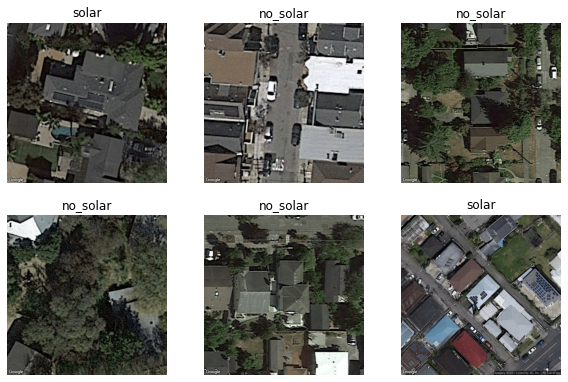

In [54]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [55]:
labels

<tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1], dtype=int32)>

## Configure datasets for performance

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## Data Augmentation

In [57]:
#data_augmentation = tf.keras.Sequential([
#  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
#  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
#])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


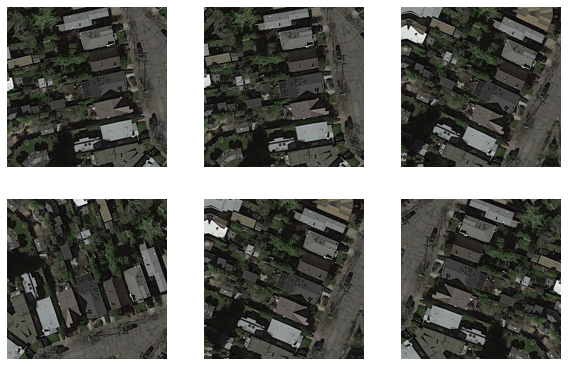

In [58]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


## Build Base Model of EfficientNet

In [144]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint(models_folder+"enb7_solar_classifier_model.h5", monitor='val_accuracy', 
                                   mode ='max', save_best_only=True, verbose=1, save_freq='epoch')

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto') 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./classification_logs/tensorboard', histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]

In [145]:
# get preprocess_input function
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [146]:
#IMG_SIZE = (240, 240)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [147]:
# extract features using base model
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(16, 19, 19, 1280)


In [148]:
# freeze the convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 600, 600, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
normalization_6 (Normalization) (None, 600, 600, 3)  7           rescaling_6[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization_6[0][0]            
_____________________________________________________________________________________

In [149]:
# add a GlobalAveragePooling2D layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(16, 1280)


In [150]:
# add a prediction layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(16, 1)


In [151]:
# prepare model
#inputs = tf.keras.Input(shape=(240, 240, 3)) 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [152]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [153]:
len(model.trainable_variables)


2

In [154]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(validation_dataset)

9/9 [==============================] - 24s 167ms/step - loss: 0.7382 - accuracy: 0.5217


In [155]:
# fit model with just top layer training
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
46/46 [==============================] - 21s 274ms/step - loss: 0.7160 - accuracy: 0.5198 - val_loss: 0.7047 - val_accuracy: 0.5145

Epoch 00001: val_accuracy improved from -inf to 0.51449, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_classifier_model.h5
Epoch 2/50
46/46 [==============================] - 11s 228ms/step - loss: 0.6868 - accuracy: 0.5375 - val_loss: 0.6897 - val_accuracy: 0.5145

Epoch 00002: val_accuracy did not improve from 0.51449
Epoch 3/50
46/46 [==============================] - 11s 228ms/step - loss: 0.6733 - accuracy: 0.5416 - val_loss: 0.6778 - val_accuracy: 0.5145

Epoch 00003: val_accuracy did not improve from 0.51449
Epoch 4/50
46/46 [==============================] - 11s 229ms/step - loss: 0.6624 - accuracy: 0.5566 - val_loss: 0.6662 - val_accuracy: 0.5217

Epoch 00004: val_accuracy improved from 0.51449 to 0.52174, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_class

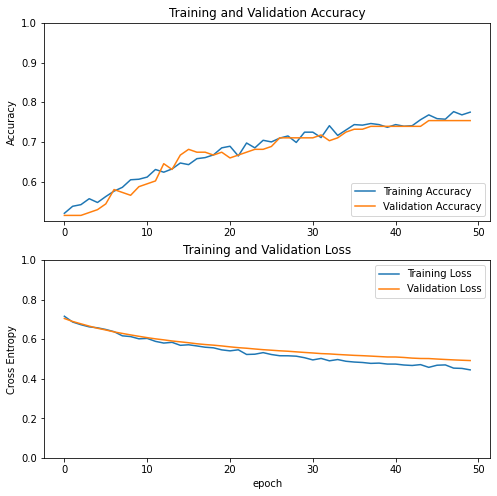

In [156]:
# plot history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Fine Tune the Model

In [157]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  339


In [158]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [159]:
# load the best saved model
#model = keras.models.load_model(models_folder + 'enb7_solar_classifier_model.h5')

# compile the model with lower learning rate
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [160]:
len(model.trainable_variables)


213

In [161]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callbacks)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 50/100
46/46 [==============================] - 46s 640ms/step - loss: 0.4130 - accuracy: 0.7899 - val_loss: 0.4213 - val_accuracy: 0.8261

Epoch 00050: val_accuracy improved from 0.75362 to 0.82609, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_classifier_model.h5
Epoch 51/100
46/46 [==============================] - 26s 557ms/step - loss: 0.3328 - accuracy: 0.8581 - val_loss: 0.3486 - val_accuracy: 0.8986

Epoch 00051: val_accuracy improved from 0.82609 to 0.89855, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_classifier_model.h5
Epoch 52/100
46/46 [==============================] - 26s 559ms/step - loss: 0.2793 - accuracy: 0.8868 - val_loss: 0.3023 - val_accuracy: 0.9130

Epoch 00052: val_accuracy improved from 0.89855 to 0.91304, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_classifier_model.h5
Epoch 53/100
46/46 [==============================] - 26s 557ms/

In [162]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


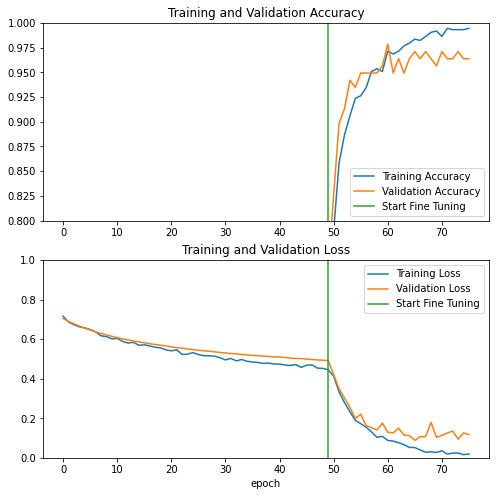

In [163]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [183]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


3/3 [==============================] - 1s 166ms/step - loss: 0.2618 - accuracy: 0.9348
Test accuracy : 0.9347826242446899


Predictions:
 [0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1]
Labels:
 [0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1]


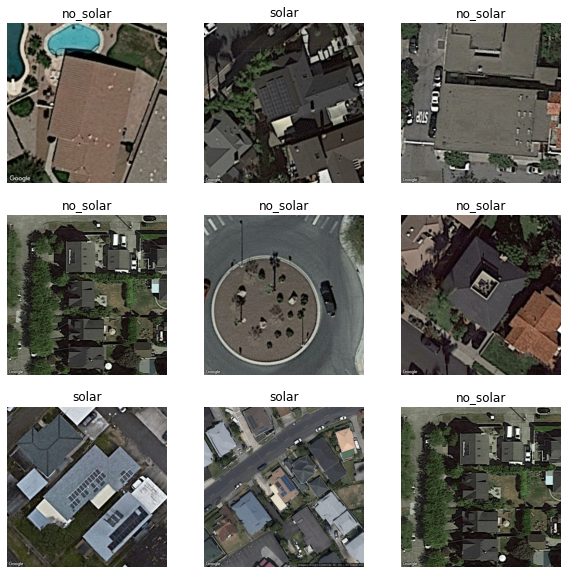

In [185]:
# retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [166]:
#model.save(models_folder + 'enb7_solar_classifier_model.h5')

In [179]:
from tensorflow import keras
saved_model_b1 = keras.models.load_model(models_folder + 'enb1_solar_classifier_model.h5')

In [180]:
loss, accuracy = saved_model_b1.evaluate(validation_dataset)
print('Validation accuracy for ENB1:', accuracy)

loss, accuracy = saved_model_b1.evaluate(test_dataset)
print('Test accuracy for ENB1:', accuracy)

9/9 [==============================] - 4s 166ms/step - loss: 0.1593 - accuracy: 0.9493
Validation accuracy for ENB1: 0.9492753744125366
3/3 [==============================] - 1s 167ms/step - loss: 0.2214 - accuracy: 0.9565
Test accuracy for ENB1: 0.95652174949646


In [176]:
saved_model_b7 = keras.models.load_model(models_folder + 'enb7_solar_classifier_model.h5')

In [182]:
loss, accuracy = saved_model_b7.evaluate(validation_dataset)
print('Validation accuracy for ENB7:', accuracy)

loss, accuracy = saved_model_b7.evaluate(test_dataset)
print('Test accuracy for ENB7:', accuracy)

9/9 [==============================] - 2s 168ms/step - loss: 0.1296 - accuracy: 0.9783
Validation accuracy for ENB7: 0.97826087474823
3/3 [==============================] - 1s 167ms/step - loss: 0.1989 - accuracy: 0.9348
Test accuracy for ENB7: 0.9347826242446899
